<h1 align="center"> Homework 19.3 </h1>

    Caelan Osman
    March 6, 2022

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are

### Exercise 19.8

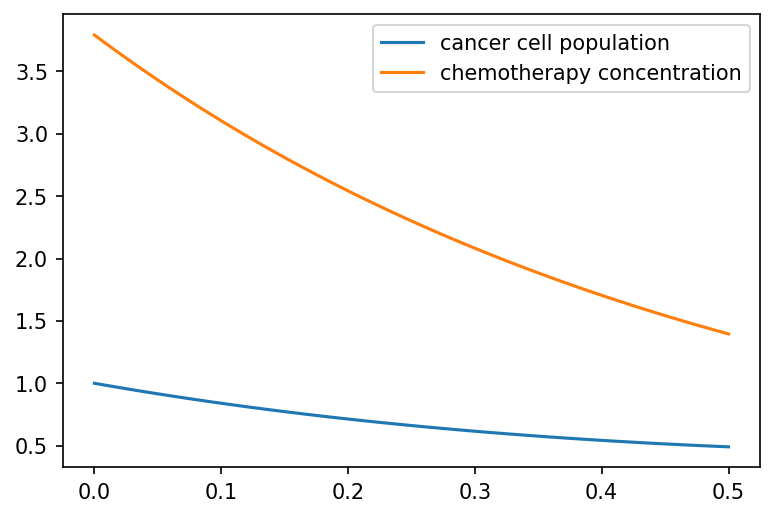

In [2]:
######################
# Given code
######################
def riccati(t,x):
    dxdt = [2*x[0]+.5*x[1],-2*x[1]]
    return dxdt

#Solve the Riccatti equation, and make sure to
#save the output densely so we can interpolate later on
xf = [1,-2]#solve backward from tf=1
p_sol = solve_ivp(riccati,[1,0],xf,dense_output=True)

#Assuming that we have an ODE solution to the Riccatti
#equation then this is the evolution of the cancer cell population
def cancer_evolve(t,x,p_sol):
    X,Y = p_sol.sol(t)
    p = -.5*Y/X 
    return (2-p)*x

#Solve the forward model for the cancer cells,
#then compute the optimal control from the optimal state, and  -plot the results
final_sol = solve_ivp(cancer_evolve,[0,1],[1],args=[p_sol], dense_output=True)
t = np.linspace(0,.5,101) 
x = final_sol.sol(t) 
X,Y = p_sol.sol(t)
p = -.5*Y/X 
u = p*x 
fig = plt.figure()
fig.set_dpi(150)
ax = fig.add_subplot(111)
ax.plot(t,np.squeeze(x))
ax.plot(t,np.squeeze(u))
ax.legend(["cancer cell population","chemotherapy concentration"])
plt.show()

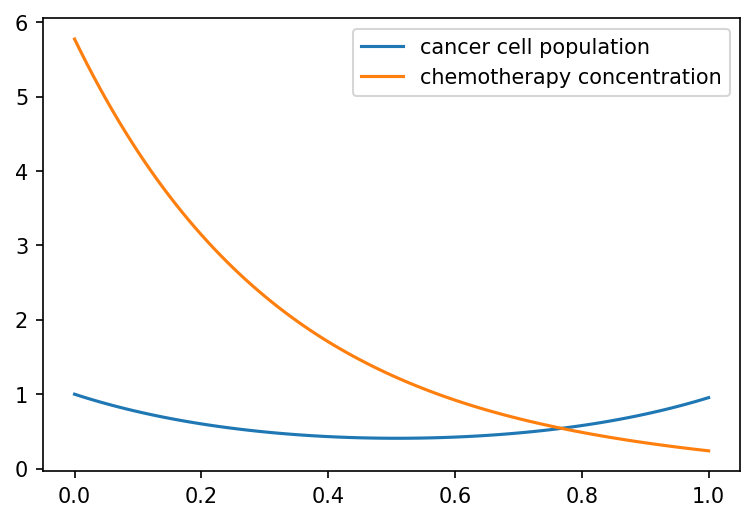

In [3]:
def chemo(alpha, R, Q, M, B=-1):
    A = alpha
    def riccati(t,x):
        dxdt = np.array([A*x[0]+ ((B*R**(-1)*B)*x[1])/2, 2*Q*x[0] -A*x[1]])
        return dxdt

    # Solve the Riccatti equation, and make sure to
    # save the output densely so we can interpolate later on
    #solve backward from tf=1
    xf = [1, -2*M]
    p_sol = solve_ivp(riccati,[1,0],xf,dense_output=True)

    # Assuming that we have an ODE solution to the Riccatti
    # equation then this is the evolution of the cancer cell 
    # population
    def cancer_evolve(t,x,p_sol):
        X, Y = p_sol.sol(t)
        p = -.5*Y/X 
        return (A - B*B*p/R)*x

    # Solve the forward model for the cancer cells,
    # then compute the optimal control from the optimal state, and
    # plot the results
    final_sol = solve_ivp(cancer_evolve,[0,1],[1],args=[p_sol], dense_output=True)
    t = np.linspace(0,1,101) 
    x = final_sol.sol(t) 
    X, Y = p_sol.sol(t)
    p = -.5*Y/X 
    u = -R**(-1)*B*p*x 
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(t,np.squeeze(x))
    ax.plot(t,np.squeeze(u))
    ax.legend(['cancer cell population','chemotherapy concentration'])
    plt.show()
    return

chemo(3, 4, 1, 1, B=-1)

 ### Exercise 19.9

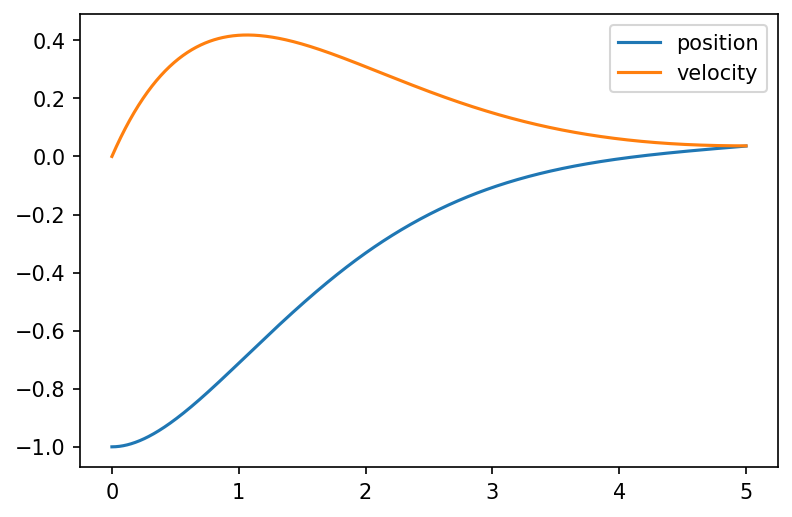

In [4]:
def car_driving_LQR_finite(q0, q1, R, x0):
    #First set up all the relevant matrices
    A=np.array([[0,1],[0,0]])
    B=np.array([[0],[1]])
    Q=np.array([[q0,0],[0,q1]])
    M = np.array([[1, 0], [0, 0]])

    # set up ricatti equation
    def ricatti(t, x):
        X = x[:4].reshape(2, 2)
        Y = x[4:].reshape(2, 2)
        P1 = A@X + (B@B.T@Y) / (2*R)
        P2 = 2*Q@X  - A.T@Y
        P = np.concatenate((P1.flatten(), P2.flatten())) 
        return P 

    # solve ricatti equation
    xf = np.concatenate((np.eye(2).flatten(), -2*M.flatten()))
    p_sol = solve_ivp(ricatti, [5, 0], xf, dense_output=True)


    # setup the evolution equation with optimal control selected
    def car_evolve(t, y):
        Z = p_sol.sol(t)
        X = Z[:4].reshape(2, 2)
        Y = Z[4:].reshape(2, 2)
        P = -Y@np.linalg.inv(X) / 2
        x = A@y - B@B.T@P@y /R
        return x.flatten()

    # solve the optimal state evolution, and plot the position & velocity
    sol = solve_ivp(car_evolve,[0,5],[-x0,0],dense_output=True)
    t = np.linspace(0,5,1001) 
    x, y = sol.sol(t)
    Z = p_sol.sol(t)
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(t,x, label='position')
    ax.plot(t,y, label='velocity')
    ax.legend(loc='best')
    plt.show()

    return

car_driving_LQR_finite(3, 2, 3, 1)

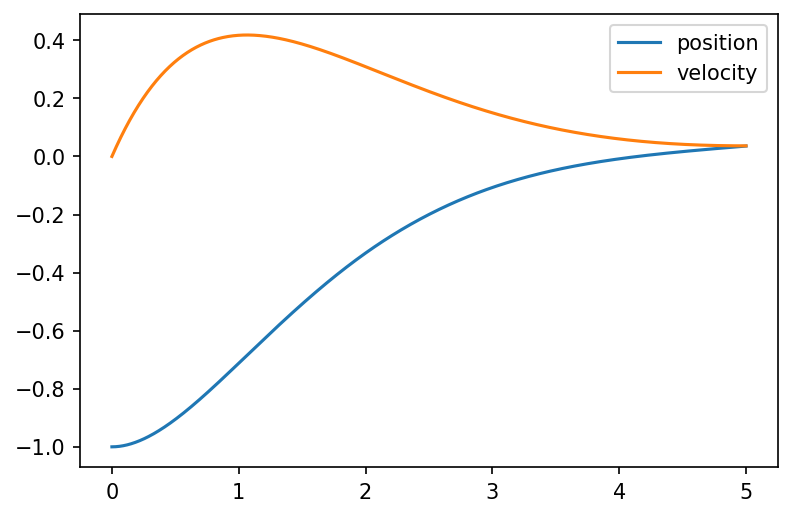

In [5]:
def car_driving_LQR_finite_2(q0, q1, R, x0):
    #First set up all the relevant matrices
    A=np.array([[0,1],[0,0]])
    B=np.array([[0],[1]])
    Q=np.array([[q0,0],[0,q1]])
    M = np.array([[1, 0], [0, 0]])

    # set up ricatti equation
    def ricatti(t, x):
        X = x.reshape(2, 2)
        P = -Q - A.T@X - X@A + X@B@B.T@X/R
        return P.flatten() 

    # solve ricatti equation
    xf = M.flatten()
    p_sol = solve_ivp(ricatti, [5, 0], xf, dense_output=True)


    # setup the evolution equation with optimal control selected
    def car_evolve(t, y):
        Z = p_sol.sol(t)
        P = Z.reshape(2, 2)
        x = A@y - (B*(R**(-1)))@B.T@P@y
        return x.flatten()

    # solve the optimal state evolution, and plot the position & velocity
    sol = solve_ivp(car_evolve,[0,5],[-x0,0],dense_output=True)
    t = np.linspace(0,5,1001) 
    x, y = sol.sol(t)
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(t,x, label='position')
    ax.plot(t,y, label='velocity')
    ax.legend(loc='best')
    plt.show()

    return

car_driving_LQR_finite_2(3, 2, 3, 1)

### Exercise 19.10

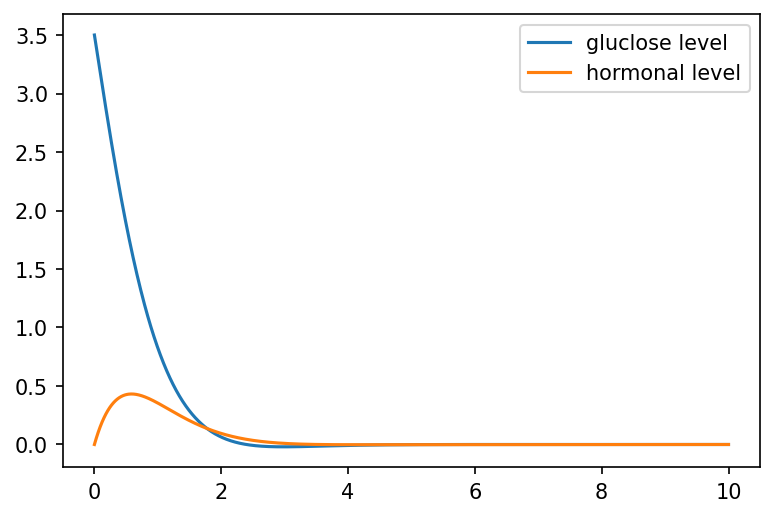

In [6]:
def gluclose_insulin_infinite_LQR(a, b, c, alpha, x0):
    #First set up all the relevant matrices
    A = np.array([[-a, -b], [0, -c]])
    B = np.array([[0], [1]])
    Q = np.array([[alpha, 0], [0, 0]])
    R = 1
    #solve the continuous algebraic Riccati equation
    P = solve_continuous_are(A,B,Q,R)

    #setup the evolution equation with optimal control selected
    def car_evolve(t, y):
        return (A- (B@B.T@P)/R)@y

    #solve the optimal state evolution, and plot the position & velocity
    sol = solve_ivp(car_evolve, [0, 10], [x0, 0], dense_output=True)
    t = np.linspace(0, 10, 1001) 
    x, y = sol.sol(t)
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(t, x, label='gluclose level')
    ax.plot(t, y, label='hormonal level')
    ax.legend(loc='best')
    plt.show()
    return

gluclose_insulin_infinite_LQR(1, 2, 1.5, 2, 3.5)